In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/ECG Time series data/

/content/drive/My Drive/Colab Notebooks/ECG Time series data


In [ ]:
!pip install -qq arff2pandas

In [ ]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from arff2pandas import a2p


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
with open('ECG5000/ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)

In [ ]:
with open('ECG5000/ECG5000_TEST.arff') as f:
  test = a2p.load(f)

In [ ]:
train.shape, test.shape

((500, 141), (4500, 141))

In [ ]:
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [ ]:
df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,-0.166753,0.011275,-0.147008,-0.088714,-0.114587,-0.146307,-0.157915,-0.027796,-0.214186,-0.141600,-0.210829,-0.203778,-0.153019,-0.266533,-0.390077,-0.327032,-0.400833,-0.407830,-0.501358,-0.522868,-0.574155,-0.659348,-0.663703,-0.724858,-0.682038,-0.770026,-0.798246,-0.747866,-0.758533,-0.591910,...,1.487003,1.675518,1.836158,1.767251,1.735520,1.630994,1.380285,1.062822,0.829051,0.559157,0.189454,-0.083072,-0.387828,-0.484409,-0.490306,-0.518586,-0.419299,-0.440095,-0.357985,-0.486044,-0.486691,-0.376997,-0.444405,-0.295011,-0.381458,-0.357774,-0.308135,-0.068073,0.510416,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,-0.262474,-0.197361,-0.340497,-0.323774,-0.335513,-0.254583,-0.264334,-0.338740,-0.284649,-0.368613,-0.394213,-0.439726,-0.368993,-0.376742,-0.423022,-0.529464,-0.589248,-0.544008,-0.518129,-0.678544,-0.717577,-0.740041,-0.769233,-0.785213,-0.821685,-0.769256,-0.772686,-0.781586,-0.818404,-0.769080,...,1.780951,1.779466,1.754980,1.696125,1.596021,1.385371,1.189426,0.954776,0.739367,0.423573,0.085743,-0.030826,-0.042948,-0.122153,-0.101229,-0.135996,-0.093358,-0.113487,-0.118484,-0.088536,-0.020003,-0.029816,-0.044748,0.034468,0.070666,0.057764,0.120260,0.417549,0.799119,1.028602,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,-0.320708,-0.359462,-0.377039,-0.397033,-0.381755,-0.427911,-0.414237,-0.448439,-0.437101,-0.362470,-0.357754,-0.360832,-0.456013,-0.426373,-0.477425,-0.551853,-0.491515,-0.540644,-0.626111,-0.672909,-0.609645,-0.674574,-0.738285,-0.711991,-0.707088,-0.719290,-0.665765,-0.681393,-0.551106,-0.678160,...,1.539706,1.861135,1.823973,1.842621,1.807378,1.673375,1.435519,1.256942,1.141169,0.773353,0.352743,-0.006171,-0.082585,-0.174300,-0.050298,-0.190888,-0.151327,-0.106006,-0.101364,-0.116433,-0.127277,0.010743,-0.166507,-0.219952,-0.076155,-0.062330,0.009366,0.151061,0.459543,0.972686,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,-0.434404,-0.391973,-0.488243,-0.431901,-0.389872,-0.552537,-0.522013,-0.412052,-0.435156,-0.485882,-0.495175,-0.472248,-0.491598,-0.542585,-0.495330,-0.514791,-0.556296,-0.654450,-0.652184,-0.705807,-0.764955,-0.806090,-0.826952,-0.834084,-0.824845,-0.894700,-0.855387,-0.843114,-0.803555,-0.649946,...,1.512614,1.786149,1.961367,1.853974,1.825461,1.679417,1.585913,1.286001,0.959101,0.604489,0.249181,-0.

In [ ]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns
df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,target
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,-0.166753,0.011275,-0.147008,-0.088714,-0.114587,-0.146307,-0.157915,-0.027796,-0.214186,-0.141600,-0.210829,-0.203778,-0.153019,-0.266533,-0.390077,-0.327032,-0.400833,-0.407830,-0.501358,-0.522868,-0.574155,-0.659348,-0.663703,-0.724858,-0.682038,-0.770026,-0.798246,-0.747866,-0.758533,-0.591910,...,1.487003,1.675518,1.836158,1.767251,1.735520,1.630994,1.380285,1.062822,0.829051,0.559157,0.189454,-0.083072,-0.387828,-0.484409,-0.490306,-0.518586,-0.419299,-0.440095,-0.357985,-0.486044,-0.486691,-0.376997,-0.444405,-0.295011,-0.381458,-0.357774,-0.308135,-0.068073,0.510416,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,-0.262474,-0.197361,-0.340497,-0.323774,-0.335513,-0.254583,-0.264334,-0.338740,-0.284649,-0.368613,-0.394213,-0.439726,-0.368993,-0.376742,-0.423022,-0.529464,-0.589248,-0.544008,-0.518129,-0.678544,-0.717577,-0.740041,-0.769233,-0.785213,-0.821685,-0.769256,-0.772686,-0.781586,-0.818404,-0.769080,...,1.780951,1.779466,1.754980,1.696125,1.596021,1.385371,1.189426,0.954776,0.739367,0.423573,0.085743,-0.030826,-0.042948,-0.122153,-0.101229,-0.135996,-0.093358,-0.113487,-0.118484,-0.088536,-0.020003,-0.029816,-0.044748,0.034468,0.070666,0.057764,0.120260,0.417549,0.799119,1.028602,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,-0.320708,-0.359462,-0.377039,-0.397033,-0.381755,-0.427911,-0.414237,-0.448439,-0.437101,-0.362470,-0.357754,-0.360832,-0.456013,-0.426373,-0.477425,-0.551853,-0.491515,-0.540644,-0.626111,-0.672909,-0.609645,-0.674574,-0.738285,-0.711991,-0.707088,-0.719290,-0.665765,-0.681393,-0.551106,-0.678160,...,1.539706,1.861135,1.823973,1.842621,1.807378,1.673375,1.435519,1.256942,1.141169,0.773353,0.352743,-0.006171,-0.082585,-0.174300,-0.050298,-0.190888,-0.151327,-0.106006,-0.101364,-0.116433,-0.127277,0.010743,-0.166507,-0.219952,-0.076155,-0.062330,0.009366,0.151061,0.459543,0.972686,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,-0.434404,-0.391973,-0.488243,-0.431901,-0.389872,-0.552537,-0.522013,-0.412052,-0.435156,-0.485882,-0.495175,-0.472248,-0.491598,-0.542585,-0.495330,-0.514791,-0.556296,-0.654450,-0.652184,-0.705807,-0.764955,-0.806090,-0.826952,-0.834084,-0.824845,-0.894700,-0.855387,-0.843114,-0.803555,-0.649946,...,1.512614,1.786149,1.961367,1.853974,1.825461,1.679417,1.585913,1.286001,0.959101,0.604489,0.249181,-0.116396,-0.2304

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


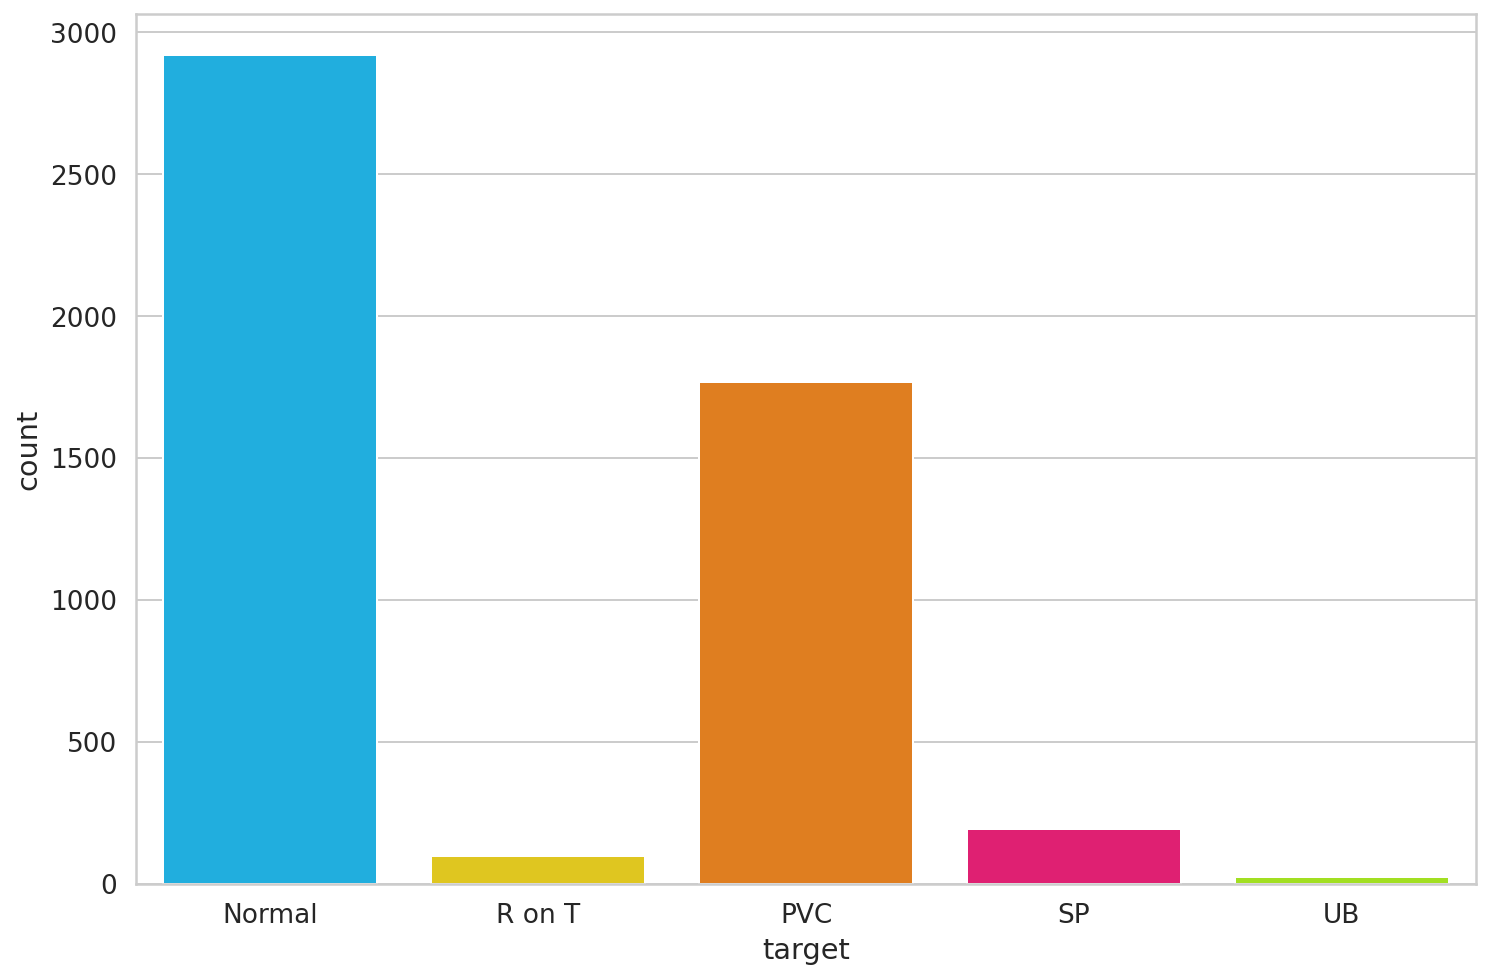

In [ ]:
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

In [ ]:
classes = df.target.unique()
classes

data = df[df.target == '1'].drop(labels='target', axis=1).mean(axis=0).to_numpy()
time_series_df = pd.DataFrame(data)
time_series_df[0:5]

,0
0,-0.374098
1,-2.204883
2,-3.291597
3,-3.955333
4,-3.858271


In [ ]:
# rolling is window of size k
time_series_df[0:5].rolling(2).mean()

,0
0,NaN
1,-1.289490
2,-2.748240
3,-3.623465
4,-3.906802


In [ ]:

smooth_path = time_series_df.rolling(10).mean()
path_deviation = 2 * time_series_df.rolling(10).std()

under_line = (smooth_path - path_deviation)[0]
over_line = (smooth_path + path_deviation)[0]

Text(0.5, 1.0, 'Normal')

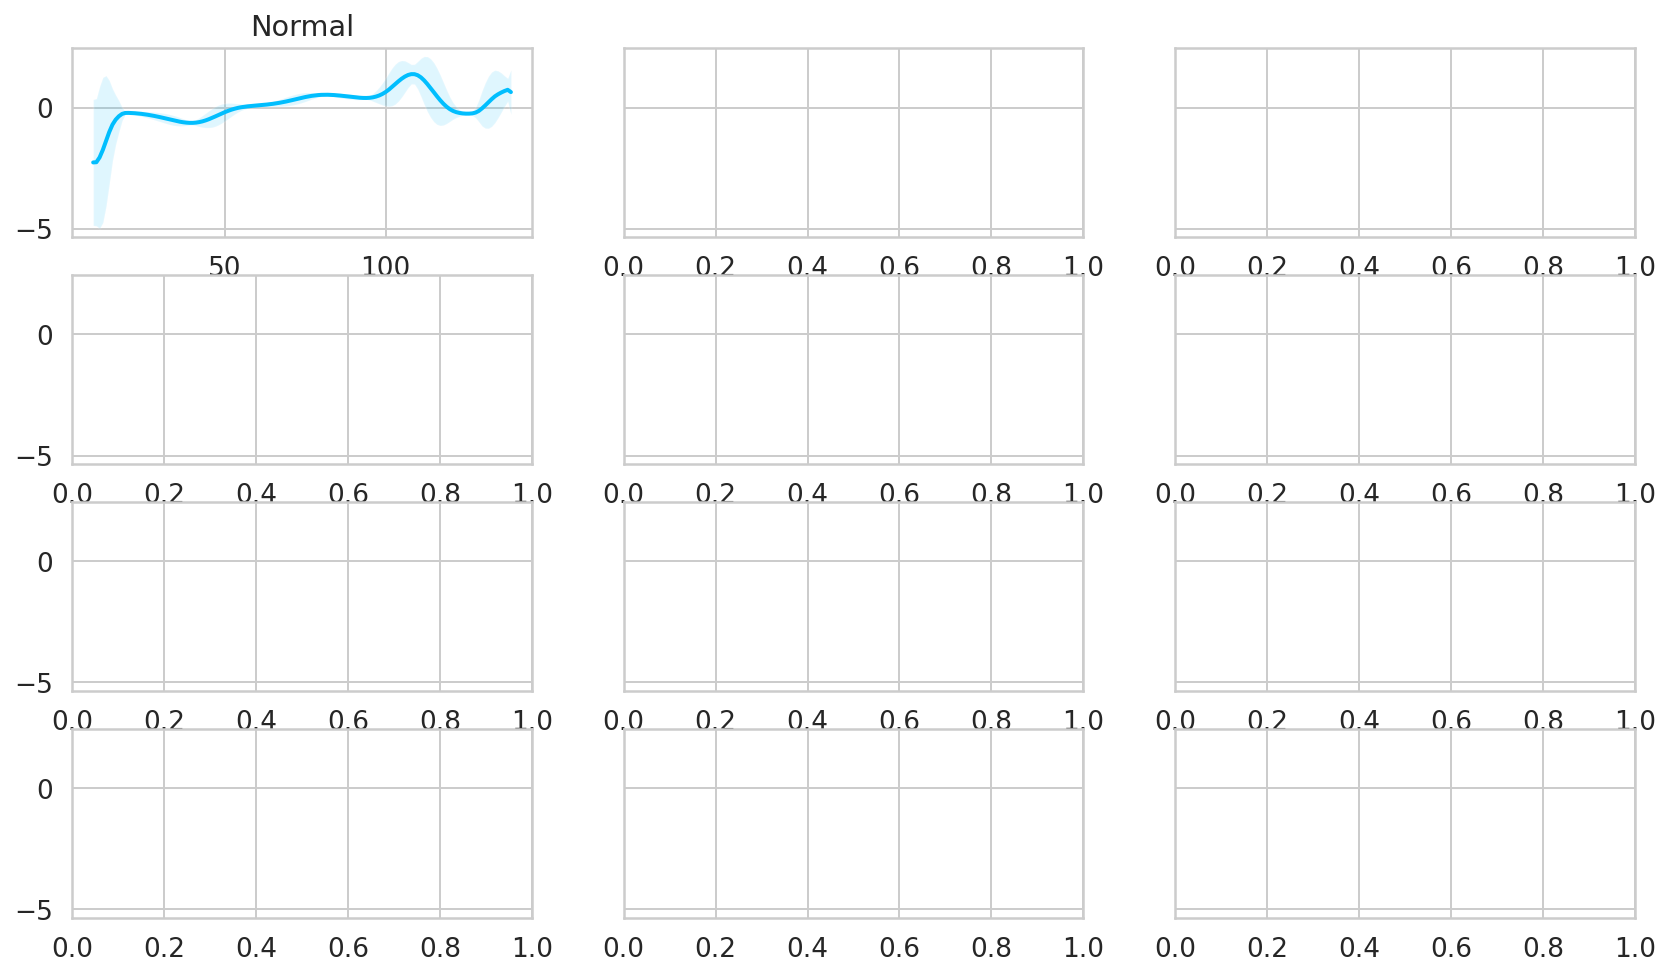

In [ ]:
fig, axs = plt.subplots(
    nrows=4,
    ncols=3,
    sharey=True,
    figsize=(14, 8)
    )

ax = axs.flat[0]

ax.plot(smooth_path, linewidth=2) #time series data!

ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125)

ax.set_title("Normal")

In [ ]:
# Preparing the dataset

In [ ]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [ ]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [ ]:
train_df, val_df = train_test_split(normal_df, test_size=0.15, random_state=RANDOM_SEED)

val_df, test_df = train_test_split(val_df, test_size=0.33, random_state=RANDOM_SEED)

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((2481, 140), (293, 140), (145, 140))

In [ ]:
s = train_df.astype(np.float32).to_numpy().tolist()

In [ ]:
torch.tensor(s).shape

torch.Size([2481, 140])

In [ ]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [ ]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [ ]:
seq_len, n_features

(140, 1)

In [ ]:
# Lets Build LSTM Autoencoder

In [ ]:
class Encoder(nn.Module):
  
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [ ]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [ ]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [ ]:
device = 'cpu'
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs):

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)

  for epoch in range(1, n_epochs + 1):

    model = model.train()
    train_losses = []

    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)
      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    print(f'Epoch {epoch}: train loss {train_loss}')

  return model

In [ ]:
model, history = train_model(
    model, 
    train_dataset, 
    val_dataset, 
    n_epochs=1
    )